## Searching patterns
Can we predict a team's final position in the league on the basis of the number of goals *scored* by the team during the season?
What about the goals *conceded*? Can we infer a relationship between these two predictors (*GoalsScored* and *GoalsConceded*) and the response, i.e. the *Points*?

Let's take a closer look to our data.

In [14]:
import numpy as np
import pandas as pd

from mysql_connection import mysql_engine

# Define the query
query = ("SELECT fp.SeasonID, fp.Season, fp.Team, fp.Points, fp.GoalsScored, fp.GoalsConceded, fp.Position, pvp.PointsPerWin, "
         "CASE WHEN Position BETWEEN 1 AND 2 THEN '1st-2nd' WHEN Position BETWEEN 3 AND 5 THEN '3rd-5th' WHEN Position BETWEEN 6 AND 10 THEN '6th-10th' "
         "ELSE '11th-last place' END AS Classified FROM FinalPositions AS fp JOIN PointsVsPositions AS pvp ON fp.SeasonID = pvp.SeasonID")

# Define the DataFrame
df = pd.read_sql(query, mysql_engine)

Here we imported the relevant data into a pandas DataFrames named `df`. Remember that it is necessary to distinguish
between seasons in which, respectively, two points or three points were assigned for each win.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2563 entries, 0 to 2562
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SeasonID       2563 non-null   int64 
 1   Season         2563 non-null   object
 2   Team           2563 non-null   object
 3   Points         2563 non-null   int64 
 4   GoalsScored    2563 non-null   int64 
 5   GoalsConceded  2563 non-null   int64 
 6   Position       2563 non-null   int64 
 7   PointsPerWin   2563 non-null   int64 
 8   Classified     2563 non-null   object
dtypes: int64(6), object(3)
memory usage: 180.3+ KB


In [21]:
print("The are " + str(df[df['PointsPerWin'] == 2].shape[0]) + " entries where 'PointsPerWin' = 2. ")
print("The are " + str(df[df['PointsPerWin'] == 3].shape[0]) + " entries where 'PointsPerWin' = 3. ")

The are 1682 entries where 'PointsPerWin' = 2. 
The are 881 entries where 'PointsPerWin' = 3. 


`df` contains a total of 2563 entries, of which 1682 are relative to seasons in which *two* points were awarded to each win,
while the remaining 881 are relative to seasons with *three* points assigned for each win.

We can look at the scatterplots of *GoalsScored* vs *Points* and *GoalsConceded* vs *Points* to better understand the relationship
between the variables.

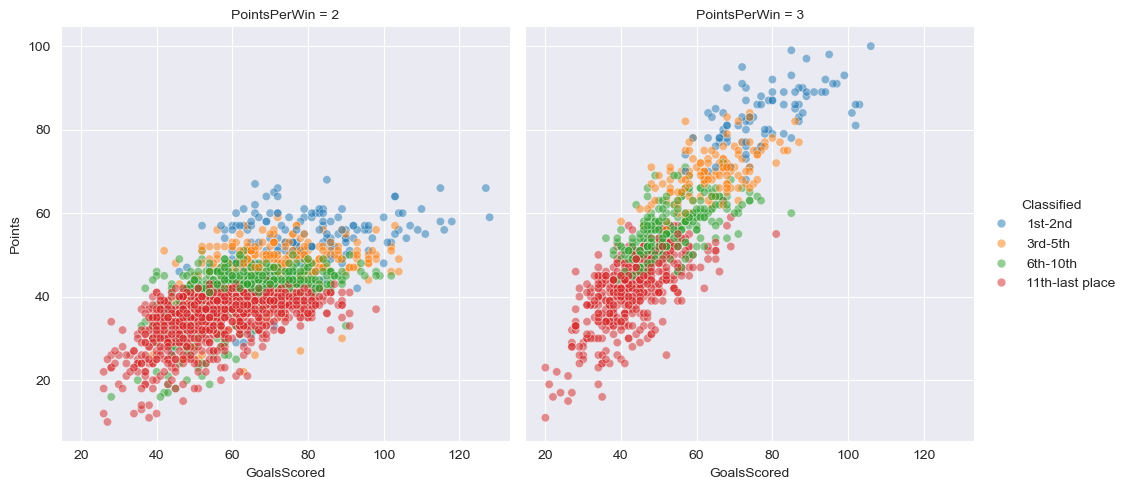

In [22]:
import seaborn as sns

sns.set_style()

sns.relplot(data=df, 
            x='GoalsScored',
            y='Points',
            col='PointsPerWin',
            hue='Classified',
            alpha=0.5,
            kind='scatter')

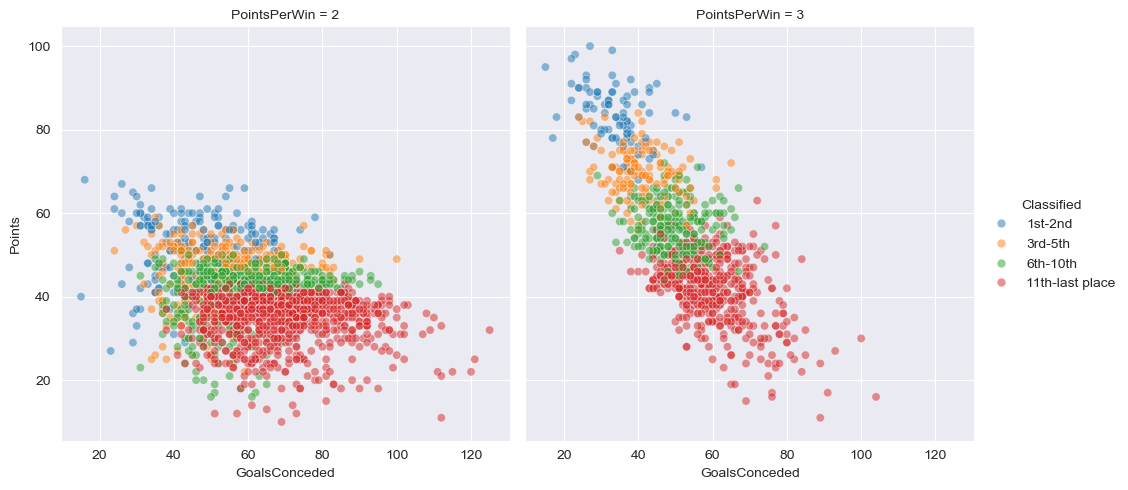

In [23]:
sns.relplot(data=df, 
            x='GoalsConceded',
            y='Points',
            col='PointsPerWin',
            hue='Classified',
            alpha=0.5,
            kind='scatter')

These plots suggest that there may be a **linear relationship** between the predictors and the response.
This can be clearly seen by looking at the data relative to seasons with three points per win,
while the existence of a linear relationship between the predictors and the *Points* seems less evident in the plots where *PointsPerWin* = 2,
especially if we consider the *GoalsConceded* variable.

### *GoalsScored* vs *Points*
To analyze this relation quantitatively, we can fit a **linear regression** model to our data by using the *method of least squares*.
We can begin by using a single predictor, for example *GoalsScored*:

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Load data from the DataFrame
# PointsPerWin = 2
goals_scored_2 = df[df['PointsPerWin'] == 2].GoalsScored.to_frame()
points_2 = df[df['PointsPerWin'] == 2].Points.to_frame()

# PointsPerWin = 3
goals_scored_3 = df[df['PointsPerWin'] == 3].GoalsScored.to_frame()
points_3 = df[df['PointsPerWin'] == 3].Points.to_frame()

# Split the data into training/testing sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(goals_scored_2, points_2)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(goals_scored_3, points_3)

# Create linear regression object and fit the training data
scored_reg_2 = LinearRegression().fit(X_train_2, y_train_2)
scored_reg_3 = LinearRegression().fit(X_train_3, y_train_3)

Let's take a look at the coefficients of our model:

In [56]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the predicted response for the training data
y_train_2_pred = scored_reg_2.predict(X_train_2)
y_train_3_pred = scored_reg_3.predict(X_train_3)

# Summarize the results
print("2 Points per win. Model: GoalsScored vs Points.")
print("\nCoefficient of the model: " + str(scored_reg_2.coef_[0][0]))
print("Intercept: " + str(scored_reg_2.intercept_[0]))
print("The training mean squared error (MSE) is %.2f" % mean_squared_error(y_train_2, y_train_2_pred))
print("The R^2 score calculated on the training set is %.2f" % r2_score(y_train_2, y_train_2_pred))
print("\n3 Points per win. Model: GoalsScored vs Points.")
print("\nCoefficient of the model: " + str(scored_reg_3.coef_[0][0]))
print("Intercept: " + str(scored_reg_3.intercept_[0]))
print("The training mean squared error (MSE) is %.2f" % mean_squared_error(y_train_3, y_train_3_pred))
print("The R^2 score calculated on the training set is %.2f" % r2_score(y_train_3, y_train_3_pred))

2 Points per win. Model: GoalsScored vs Points.

Coefficient of the model: 0.36729507577184584
Intercept: 16.85379193313398
The training mean squared error (MSE) is 47.02
The R^2 score calculated on the training set is 0.41

3 Points per win. Model: GoalsScored vs Points.

Coefficient of the model: 0.941750969737695
Intercept: 4.361120249758137
The training mean squared error (MSE) is 61.63
The R^2 score calculated on the training set is 0.76


We can see that the model performs better on the data corresponding to seasons with three points awarded for each win, 
as the $R^2$ value is substantially higher in this case.
Notice also that the value of the intercept in the model trained with the two points per win data seems highly unreasonable,
as it would suggest that, on average, a team that scores no goals during the entire seasons would still finish the league with more than 16 points.
These observations indicate that this simple model is not very accurate, and it should be rejected at least for the dataset relative to the seasons with 2 points per win.

For a better evaluation of the model, however, we must analyze its performance on the test dataset:

In [57]:
# Calculate the predicted response for the testing data
y_test_2_pred = scored_reg_2.predict(X_test_2)
y_test_3_pred = scored_reg_3.predict(X_test_3)

# Summarize the results
print("2 Points per win. Model: GoalsScored vs Points.")
print("The testing mean squared error (MSE) is %.2f" % mean_squared_error(y_test_2, y_test_2_pred))
print("The R^2 score calculated on the testing set is %.2f" % r2_score(y_test_2, y_test_2_pred))
print("\n3 Points per win. Model: GoalsScored vs Points.")
print("The testing mean squared error (MSE) is %.2f" % mean_squared_error(y_test_3, y_test_3_pred))
print("The R^2 score calculated on the testing set is %.2f" % r2_score(y_test_3, y_test_3_pred))

2 Points per win. Model: GoalsScored vs Points.
The testing mean squared error (MSE) is 42.78
The R^2 score calculated on the testing set is 0.42

3 Points per win. Model: GoalsScored vs Points.
The testing mean squared error (MSE) is 63.28
The R^2 score calculated on the testing set is 0.74


We can see that, even after using a testing dataset, the scores of the model remain substantially unaltered.

### *GoalsConceded* vs *Points*
We can now repeat the same analysis using the *GoalsConceded* as a predictor for the *Points*.

In [58]:
# Load data from the DataFrame
# PointsPerWin = 2
goals_conceded_2 = df[df['PointsPerWin'] == 2].GoalsConceded.to_frame()

# PointsPerWin = 3
goals_conceded_3 = df[df['PointsPerWin'] == 3].GoalsConceded.to_frame()

# Split the data into training/testing sets
XX_train_2, XX_test_2, yy_train_2, yy_test_2 = train_test_split(goals_conceded_2, points_2)
XX_train_3, XX_test_3, yy_train_3, yy_test_3 = train_test_split(goals_conceded_3, points_3)

# Create linear regression object and fit the training data
conceded_reg_2 = LinearRegression().fit(XX_train_2, yy_train_2)
conceded_reg_3 = LinearRegression().fit(XX_train_3, yy_train_3)

# Calculate the predicted response for the training data
yy_train_2_pred = conceded_reg_2.predict(XX_train_2)
yy_train_3_pred = conceded_reg_3.predict(XX_train_3)

# Calculate the predicted response for the testing data
yy_test_2_pred = conceded_reg_2.predict(XX_test_2)
yy_test_3_pred = conceded_reg_3.predict(XX_test_3)

# Summarize the results
print("2 Points per win. Model: GoalsConceded vs Points.")
print("\nCoefficient of the model: " + str(conceded_reg_2.coef_[0][0]))
print("Intercept: " + str(conceded_reg_2.intercept_[0]))
print("The training mean squared error (MSE) is %.2f" % mean_squared_error(yy_train_2, yy_train_2_pred))
print("The R^2 score calculated on the training set is %.2f" % r2_score(yy_train_2, yy_train_2_pred))
print("\nThe testing mean squared error (MSE) is %.2f" % mean_squared_error(yy_test_2, yy_test_2_pred))
print("The R^2 score calculated on the testing set is %.2f" % r2_score(yy_test_2, yy_test_2_pred))
print("\n3 Points per win. Model: GoalsConceded vs Points.")
print("\nCoefficient of the model: " + str(conceded_reg_3.coef_[0][0]))
print("Intercept: " + str(conceded_reg_3.intercept_[0]))
print("The training mean squared error (MSE) is %.2f" % mean_squared_error(yy_train_3, yy_train_3_pred))
print("The R^2 score calculated on the training set is %.2f" % r2_score(yy_train_3, yy_train_3_pred))
print("\nThe testing mean squared error (MSE) is %.2f" % mean_squared_error(yy_test_3, yy_test_3_pred))
print("The R^2 score calculated on the testing set is %.2f" % r2_score(yy_test_3, yy_test_3_pred))

2 Points per win. Model: GoalsConceded vs Points.

Coefficient of the model: -0.1791198074666159
Intercept: 50.88909635842943
The training mean squared error (MSE) is 70.33
The R^2 score calculated on the training set is 0.10

The testing mean squared error (MSE) is 69.30
The R^2 score calculated on the testing set is 0.10

3 Points per win. Model: GoalsConceded vs Points.

Coefficient of the model: -0.9394030890818462
Intercept: 102.52595746154016
The training mean squared error (MSE) is 101.67
The R^2 score calculated on the training set is 0.59

The testing mean squared error (MSE) is 104.71
The R^2 score calculated on the testing set is 0.61


As we could expect, the coefficient of the regression line is negative: the fewer goals one team concedes, the more points it will obtain.
When we train the model with the two points per win data, it achieves an extremely low $R^2$ score (10%); this was already clear when we first looked at the scatterplot of *GoalsConceded* vs *Points*.
When we use the data relative to seasons with three points per win the model performs far better, achieving an $R^2$ score of 61%;
this result, however, is not sufficient to conclude with certainty that a linear relationship exists.

### Multiple linear regression
We can make one more attempt to find a linear relationship between the two predictors (*GoalsScored* and *GoalsConceded*) and the number of *Points* by fitting a multiple linear regression model.

In [63]:
# Load data from the DataFrame
# PointsPerWin = 2
predictors_2 = df[df['PointsPerWin'] == 2][['GoalsScored', 'GoalsConceded']]

# PointsPerWin = 3
predictors_3 = df[df['PointsPerWin'] == 3][['GoalsScored', 'GoalsConceded']]

# Split the data into training/testing sets
multiple_X_train_2, multiple_X_test_2, multiple_y_train_2, multiple_y_test_2 = train_test_split(predictors_2, points_2)
multiple_X_train_3, multiple_X_test_3, multiple_y_train_3, multiple_y_test_3 = train_test_split(predictors_3, points_3)

# Create linear regression object and fit the training data
multiple_reg_2 = LinearRegression().fit(multiple_X_train_2, multiple_y_train_2)
multiple_reg_3 = LinearRegression().fit(multiple_X_train_3, multiple_y_train_3)

# Calculate the predicted response for the training data
multiple_y_train_2_pred = multiple_reg_2.predict(multiple_X_train_2)
multiple_y_train_3_pred = multiple_reg_3.predict(multiple_X_train_3)

# Calculate the predicted response for the testing data
multiple_y_test_2_pred = multiple_reg_2.predict(multiple_X_test_2)
multiple_y_test_3_pred = multiple_reg_3.predict(multiple_X_test_3)

# Summarize the results
print("2 Points per win. Model: (GoalsScored, GoalsConceded) vs Points.")
print("\nCoefficients of the model:")
print("GoalsScored -> " + str(multiple_reg_2.coef_[0][0]))
print("GoalsConceded -> " + str(multiple_reg_2.coef_[0][1]))
print("Intercept -> " + str(multiple_reg_2.intercept_[0]))
print("The training mean squared error (MSE) is %.2f" % mean_squared_error(multiple_y_train_2, multiple_y_train_2_pred))
print("The R^2 score calculated on the training set is %.2f" % r2_score(multiple_y_train_2, multiple_y_train_2_pred))
print("\nThe testing mean squared error (MSE) is %.2f" % mean_squared_error(multiple_y_test_2, multiple_y_test_2_pred))
print("The R^2 score calculated on the testing set is %.2f" % r2_score(multiple_y_test_2, multiple_y_test_2_pred))
print("\n3 Points per win. Model: (GoalsScored, GoalsConceded) vs Points.")
print("\nCoefficients of the model:")
print("GoalsScored -> " + str(multiple_reg_3.coef_[0][0]))
print("GoalsConceded -> " + str(multiple_reg_3.coef_[0][1]))
print("Intercept -> " + str(multiple_reg_3.intercept_[0]))
print("The training mean squared error (MSE) is %.2f" % mean_squared_error(multiple_y_train_3, multiple_y_train_3_pred))
print("The R^2 score calculated on the training set is %.2f" % r2_score(multiple_y_train_3, multiple_y_train_3_pred))
print("\nThe testing mean squared error (MSE) is %.2f" % mean_squared_error(multiple_y_test_3, multiple_y_test_3_pred))
print("The R^2 score calculated on the testing set is %.2f" % r2_score(multiple_y_test_3, multiple_y_test_3_pred))

2 Points per win. Model: (GoalsScored, GoalsConceded) vs Points.

Coefficients of the model:
GoalsScored -> 0.43545604005898403
GoalsConceded -> -0.2870849311994745
Intercept -> 30.47835501265844
The training mean squared error (MSE) is 28.36
The R^2 score calculated on the training set is 0.65

The testing mean squared error (MSE) is 20.96
The R^2 score calculated on the testing set is 0.71

3 Points per win. Model: (GoalsScored, GoalsConceded) vs Points.

Coefficients of the model:
GoalsScored -> 0.6971841416531843
GoalsConceded -> -0.5509785423637005
Intercept -> 45.86213675751893
The training mean squared error (MSE) is 23.79
The R^2 score calculated on the training set is 0.90

The testing mean squared error (MSE) is 24.10
The R^2 score calculated on the testing set is 0.91


We see that the multiple linear regression model performs well on the 2 points per win test dataset, achieving an $R^2$ score of 71% that is substantially higher than both the models trained with a single predictor and tested on the analogous dataset (42% for *GoalsScored* vs *Points* and only 10% for *GoalsConceded* vs *Points*).
The model performs even better when evaluated on the 3 points per win test dataset, achieving an $R^2$ of 91% versus the 74% of *GoalsScored* vs *Points* and the 61% of *GoalsConceded* vs *Points*. 

# Test visualizations
In this last section we plot some sample visualizations obtained using the functions defined in the file 'visualizations.py'.

### `pie_chart_results()`
The function `pie_chart_results()` provides an overview of the results of a given team during its history in the league.
The resulting chart illustrates the total number of wins, draws and losses of the team subdivided with respect to home matches and away matches.

**Example**

In [79]:
import visualizations as vis

vis.pie_chart_results('Liverpool')

file:///var/folders/hy/v0zvd7kj7c39bc6p1g5m0qw00000gn/T/tmp2b5pdzex.html


### `show_positions()`
The function `show_positions()` takes three required arguments: a list of teams, a start season and an end season. As a result, it generates a plot showing the positions of the given teams in the seasons between the period specified.
`show_positions()` is a useful tool to compare the performance of two or more teams in a given period of time.

**Example**

In [81]:
vis.show_positions(['Manchester Utd', 
                    'Manchester City', 
                    'Chelsea', 
                    'Arsenal'],
                   '1973/1974',
                   '1991/1992')

file:///var/folders/hy/v0zvd7kj7c39bc6p1g5m0qw00000gn/T/tmp73f51bj_.html
